## Find the 50 nearest turbines in area DK1 to the first turbine based on their UTM coordinates using the Nearest Neighbors algorithm.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

# ================================
# Step 1: read settlement and filter turbines
# ================================
settlement = pd.read_parquet("energinet/settlement/2019.parquet")

# convert VAERDI to numeric, coerce errors to NaN
settlement["VAERDI"] = pd.to_numeric(settlement["VAERDI"], errors="coerce")

# compute mean power per GSRN and filter those with mean > 0
mean_power_per_gsrn = settlement.groupby("GSRN")["VAERDI"].mean()
valid_gsrns = set(mean_power_per_gsrn[mean_power_per_gsrn > 0].index)

# ================================
# Step 2: read masterdatawind and filter turbines
# ================================
df = pd.read_parquet("energinet/masterdatawind.parquet")

# keep only W-type turbines with valid UTM coordinates and in valid_gsrns
df = df[
    (df["Turbine_type"] == "W") &
    (df["UTM_x"].notnull()) &
    (df["UTM_y"].notnull()) &
    (df["GSRN"].isin(valid_gsrns))
].copy()

# drop duplicates, keep the earliest In_service date
df = df.sort_values("In_service").drop_duplicates(subset="GSRN", keep="first")

# ================================
# Step 3: Nearest Neighbors selection
# ================================
coords = df[["UTM_x", "UTM_y"]].values
model = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(coords)
_, indices = model.kneighbors([coords[0]])

# select the 50 turbines
selected = df.iloc[indices[0]].copy()

# ================================
# Step 4: output results
# ================================
print("Selected 50 W-type turbines with non-zero generation in 2019:")
print(selected[["GSRN", "Turbine_name", "UTM_x", "UTM_y", "Capacity_kw", "In_service"]])

# save to CSV
selected.to_csv("selected_50_turbines_filtered.csv", index=False)

Selected 50 W-type turbines with non-zero generation in 2019:
                     GSRN                            Turbine_name       UTM_x  \
85087  571313174116253585              Frederiksborgvej 399, 4000  694932.000   
10617  570714700000106958                   Forskningscenter Risø  694694.000   
1747   570714700000004575                   Forskningscenter Risø  694665.000   
1776   570714700000004605                  Klaus Hartmann Nielsen  697337.000   
1740   570714700000004568                  Kongemarkens Vindmølle  689965.000   
2126   570714700000005213                                Darupvej  693240.770   
1895   570714700000004810             Jens Frellsen Trællerupgård  686396.000   
1956   570714700000004964                               Ole Olsen  702955.000   
1719   570714700000004513                         Flemming Jensen  694942.000   
70172  570715000000107078                                    IKEA  706543.000   
10562  570714700000106699                  Bram

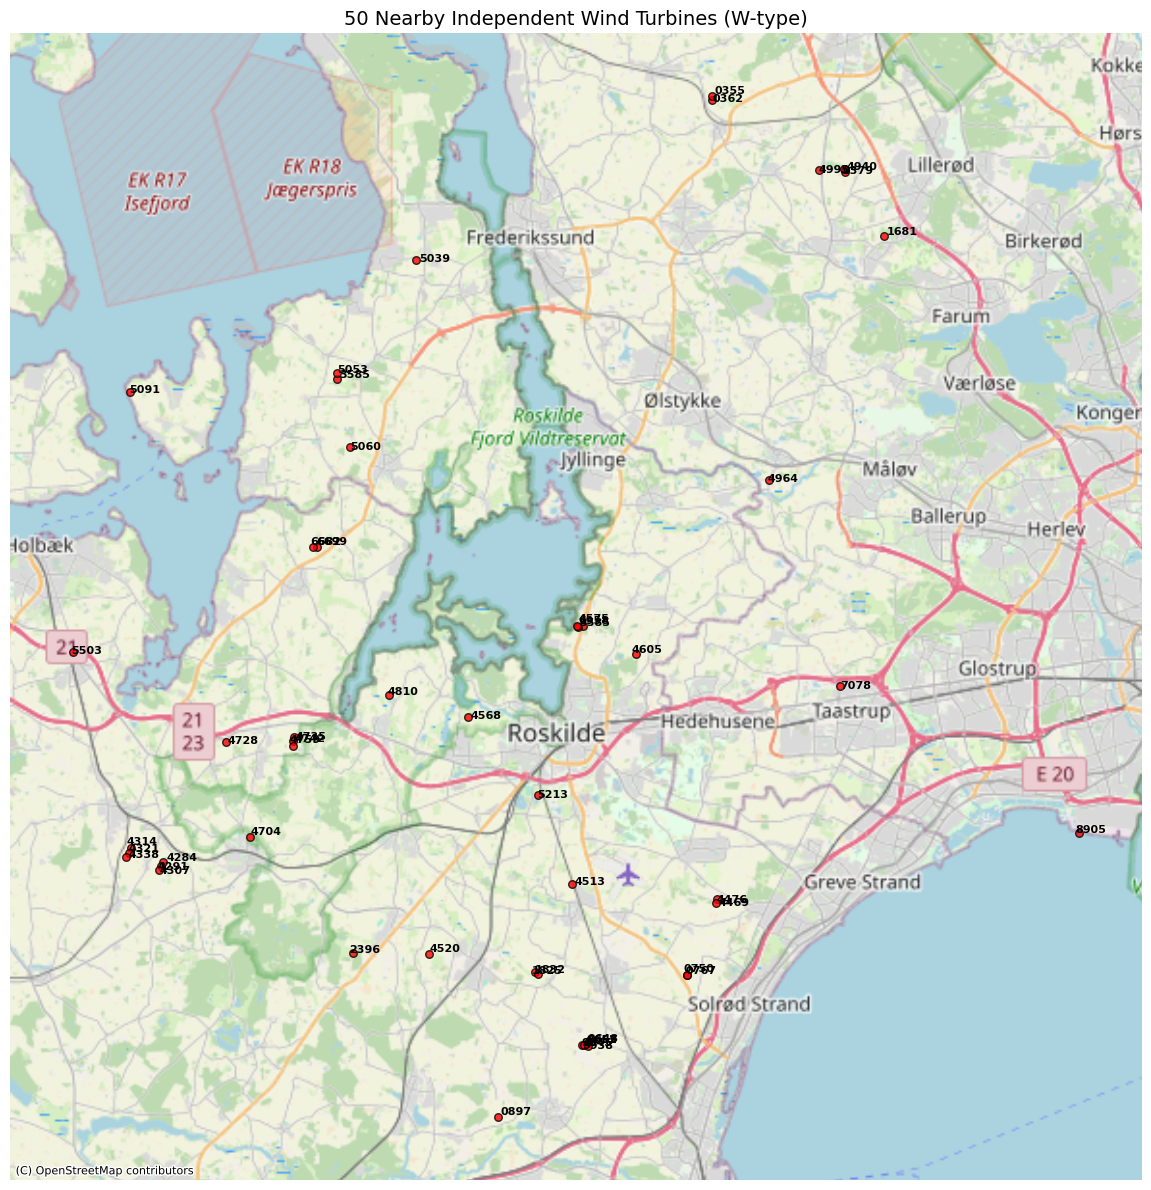

In [2]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import random

# create a GeoDataFrame from selected turbines
selected_gdf = gpd.GeoDataFrame(
    selected,
    geometry=gpd.points_from_xy(selected["UTM_x"], selected["UTM_y"]),
    crs="EPSG:25832"
)

# transform to Web Mercator for plotting with contextily
selected_gdf = selected_gdf.to_crs(epsg=3857)

# draw
fig, ax = plt.subplots(figsize=(12, 12))  # 更大画布

# draw points for turbines
selected_gdf.plot(ax=ax, color='red', markersize=30, edgecolor='black', alpha=0.8)

# add labels with slight random offset to avoid overlap
for idx, row in selected_gdf.iterrows():
    gsrn_suffix = str(row["GSRN"])[-4:]
    dx = random.randint(-300, 300)
    dy = random.randint(-300, 300)
    ax.text(row.geometry.x + dx, row.geometry.y + dy, gsrn_suffix,
            fontsize=8, color='black', weight='bold')

# set auto limits with extra padding to zoom out
ax.set_xlim(selected_gdf.total_bounds[0] - 5000, selected_gdf.total_bounds[2] + 5000)
ax.set_ylim(selected_gdf.total_bounds[1] - 5000, selected_gdf.total_bounds[3] + 5000)

# add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# finalize plot by removing axes and adding title
plt.axis("off")
plt.title("50 Nearby Independent Wind Turbines (W-type)", fontsize=14)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ---------- STEP 1: read selected turbines ----------
selected_gsrns = [str(g) for g in selected["GSRN"].tolist()]

# ---------- STEP 2: read settlement and filter turbines ----------
settlement = pd.read_parquet("energinet/settlement/2019.parquet")
settlement["GSRN"] = settlement["GSRN"].astype(str)
df_settle = settlement[settlement["GSRN"].isin(selected_gsrns)].copy()

# ---------- STEP 3: parse time fields ----------
df_settle["timestamp"] = pd.to_datetime(df_settle["TIME_CET"])
df_settle["hour"] = df_settle["timestamp"].dt.hour
df_settle["date"] = df_settle["timestamp"].dt.date

# ---------- STEP 4: feature engineering ----------
feature_list = []

for gsrn, group in df_settle.groupby("GSRN"):
    power = pd.to_numeric(group["VAERDI"], errors="coerce")  # NaNs will be kept
    mean_power = power.mean()
    std_power = power.std()
    cv = std_power / mean_power if mean_power else None
    zero_ratio = (power == 0).mean()
    ramp_rate = power.diff()
    ramp_mean = ramp_rate.mean()
    ramp_std = ramp_rate.std()

    feature_list.append({
        "GSRN": gsrn,
        "mean_power": mean_power,
        "std_power": std_power,
        "cv": cv,
        "zero_ratio": zero_ratio,
        "ramp_mean": ramp_mean,
        "ramp_std": ramp_std,
    })

features_df = pd.DataFrame(feature_list)

# ---------- STEP 5: check and drop invalid turbines ----------
print(" Initial turbine count:", len(features_df))
invalid_rows = features_df[features_df.isna().any(axis=1) | (features_df["mean_power"] == 0)]
if not invalid_rows.empty:
    print("\n Turbines with invalid feature values (NaN or mean_power=0):")
    print(invalid_rows[["GSRN", "mean_power", "std_power", "cv", "ramp_mean"]])

features_df = features_df.dropna().copy()
features_df = features_df[features_df["mean_power"] != 0].copy()
print(" Valid turbines retained:", len(features_df))

# ---------- STEP 6: feature scaling ----------
columns_to_scale = ["mean_power", "std_power", "cv", "ramp_mean", "ramp_std"]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(features_df[columns_to_scale])

scaled_df = pd.DataFrame(scaled_values, columns=[f"{col}_scaled" for col in columns_to_scale])
scaled_df["GSRN"] = features_df["GSRN"].values  # ensure alignment

# Combine original and scaled
features_df = features_df.merge(scaled_df, on="GSRN")

# ---------- STEP 7: output and save ----------
pd.set_option("display.precision", 4)
print("\n Final scaled features preview:")
print(features_df.head())

output_path = "features_in_group_stage_50_turbines.csv"
features_df.to_csv(output_path, index=False)
print(f"\n  Features saved to: {output_path}")

 Initial turbine count: 50
 Valid turbines retained: 50

 Final scaled features preview:
                 GSRN  mean_power  std_power      cv  zero_ratio  ramp_mean  \
0  570714700000000355    122.1521   148.7741  1.2179      0.1135    -0.0057   
1  570714700000000362    119.8371   146.6536  1.2238      0.1104    -0.0060   
2  570714700000000379     77.8689   105.2168  1.3512      0.3335    -0.0107   
3  570714700000003585     30.2016    44.3386  1.4681      0.2265    -0.0018   
4  570714700000004469      5.0354    19.3422  3.8413      0.8865    -0.0139   

   ramp_std  mean_power_scaled  std_power_scaled  cv_scaled  ramp_mean_scaled  \
0   47.5553             0.0852            0.1458    -0.2268           -0.2975   
1   47.7507             0.0737            0.1336    -0.2251           -0.3114   
2   33.9353            -0.1356           -0.1061    -0.1884           -0.6160   
3   13.5845            -0.3733           -0.4582    -0.1548           -0.0438   
4    4.8142            -0.4988 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ---------- Step 0: get selected turbines ----------
selected["GSRN"] = selected["GSRN"].astype(str)
selected_gsrns = selected["GSRN"].tolist()
capacity_map = dict(zip(selected["GSRN"], selected["Capacity_kw"]))

# ---------- Step 1: load power generation data ----------
settlement = pd.read_parquet("energinet/settlement/2019.parquet")
settlement["timestamp"] = pd.to_datetime(settlement["TIME_CET"])
settlement["VAERDI"] = pd.to_numeric(settlement["VAERDI"], errors="coerce")
settlement["GSRN"] = settlement["GSRN"].astype(str)
settlement = settlement[settlement["GSRN"].isin(selected_gsrns)].copy()

# Normalize VAERDI by Capacity_kw
settlement["Capacity_kw"] = settlement["GSRN"].map(capacity_map)
settlement["VAERDI_norm"] = settlement["VAERDI"] / settlement["Capacity_kw"]

# ---------- Step 2: load wind speed data and flatten ----------
raw_wind = pd.read_parquet("energinet/prognosis/ENetNEA/wind_speed_100m.parquet")
wind_long = raw_wind.drop(columns=["predicted_ahead"]).copy()
wind_long = wind_long.melt(var_name="offset_hour", value_name="wind_speed")
wind_long["offset_hour"] = pd.to_numeric(wind_long["offset_hour"], errors="coerce")
base_time = pd.Timestamp("2019-01-01 00:00:00")
wind_long["timestamp"] = base_time + pd.to_timedelta(wind_long["offset_hour"], unit="h")
avg_wind = wind_long.groupby("timestamp")["wind_speed"].mean().reset_index()

# ---------- Step 3: merge two data sources ----------
merged = pd.merge(
    settlement[["GSRN", "timestamp", "VAERDI_norm"]],
    avg_wind,
    on="timestamp",
    how="inner"
).dropna()

# ---------- Step 4: extract features for each turbine ----------
results = []

for gsrn, group in merged.groupby("GSRN"):
    group = group.sort_values("timestamp").copy()

    # Feature 1: Residual MSE by Wind Speed bin
    group["wind_bin"] = pd.cut(group["wind_speed"], bins=np.arange(0, 26, 2))
    residuals = []

    for _, bin_df in group.groupby("wind_bin", observed=True):
        if len(bin_df) >= 5:
            x = bin_df[["wind_speed"]]
            y = bin_df["VAERDI_norm"]
            model = LinearRegression().fit(x, y)
            y_pred = model.predict(x)
            mse = mean_squared_error(y, y_pred)
            residuals.append(mse)

    residual_mse = np.mean(residuals) if residuals else np.nan

    # Feature 2: Daily Power Curve
    group["hour"] = group["timestamp"].dt.hour
    hourly_mean = group.groupby("hour")["VAERDI_norm"].mean().reindex(range(24), fill_value=np.nan)
    daily_profile = hourly_mean.values

    # Feature 3: Fourier components
    fourier_coeffs = np.fft.fft(daily_profile)
    fourier_features = np.abs(fourier_coeffs[:5])

    results.append({
        "GSRN": gsrn,
        "residual_mse": residual_mse,
        **{f"hour_{i}": v for i, v in enumerate(daily_profile)},
        **{f"fft_{i}": v for i, v in enumerate(fourier_features)}
    })

# ---------- Step 5: output results and save to CSV ----------
features_df = pd.DataFrame(results)
pd.set_option("display.precision", 4)
print(features_df.head())

features_df.to_csv("power_curve_features_in_group_stage_50_turbines.csv", index=False)

                 GSRN  residual_mse  hour_0  hour_1  hour_2  hour_3  hour_4  \
0  570714700000000355        0.0365  0.1902  0.1817  0.1969  0.1693  0.2140   
1  570714700000000362        0.0343  0.1796  0.1765  0.1933  0.1786  0.2077   
2  570714700000000379        0.0300  0.1471  0.1621  0.1430  0.1598  0.1639   
3  570714700000003585        0.0379  0.1451  0.1334  0.2009  0.1777  0.1858   
4  570714700000004469        0.0040  0.0025  0.0006  0.0376  0.0267  0.0287   

   hour_5  hour_6  hour_7  ...  hour_19  hour_20  hour_21  hour_22  hour_23  \
0  0.2354  0.2077  0.2068  ...   0.1703   0.1705   0.1885   0.2142   0.1995   
1  0.2312  0.1882  0.1991  ...   0.1572   0.1597   0.1871   0.2071   0.1958   
2  0.1880  0.1702  0.1722  ...   0.1332   0.1578   0.1607   0.1927   0.1645   
3  0.2358  0.1696  0.1852  ...   0.1099   0.1406   0.1699   0.2084   0.1796   
4  0.0369  0.0000  0.0000  ...   0.0169   0.0372   0.0291   0.0440   0.0506   

    fft_0   fft_1   fft_2   fft_3   fft_4  
0  4.7

/var/folders/rx/y63trwp10b9dm1lbhqqv7_rw0000gn/T/ipykernel_89246/3009070545.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', len(selected_gsrns))


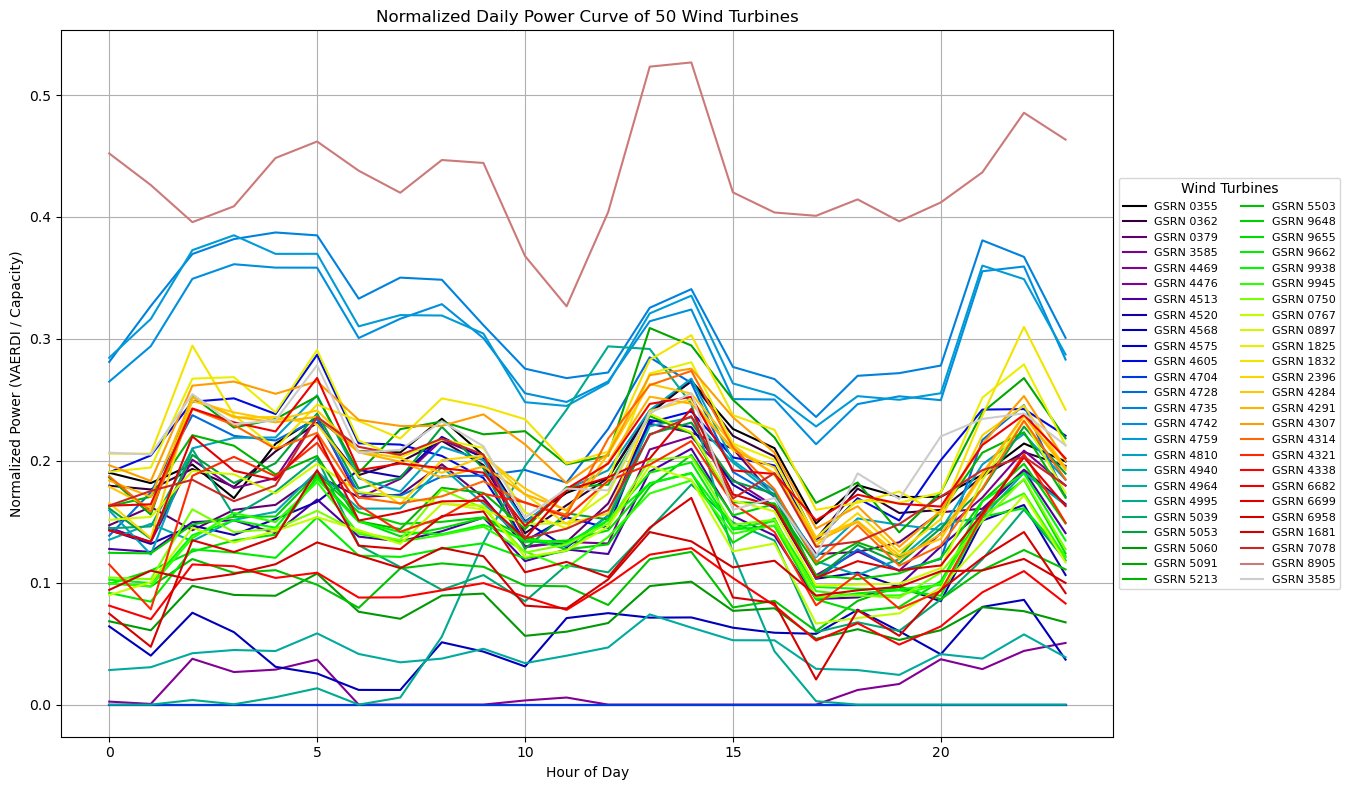

In [5]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# 提取 GSRN 列表和匹配数据
selected_gsrns = selected["GSRN"].astype(str).tolist()
features_df = features_df[features_df["GSRN"].isin(selected_gsrns)].copy()

# 使用色彩更丰富的 colormap（支持 50 个不同颜色）
cmap = cm.get_cmap('nipy_spectral', len(selected_gsrns))
colors = [cmap(i) for i in range(len(selected_gsrns))]

# 创建图像
plt.figure(figsize=(16, 8))

# 绘制每一条曲线
for i, (_, row) in enumerate(features_df.iterrows()):
    hours = list(range(24))
    values = [row[f"hour_{h}"] for h in hours]
    gsrn_suffix = str(row["GSRN"])[-4:]
    plt.plot(hours, values, label=f"GSRN {gsrn_suffix}", color=colors[i], linewidth=1.5)

# 添加标题和坐标轴
plt.title("Normalized Daily Power Curve of 50 Wind Turbines")
plt.xlabel("Hour of Day")
plt.ylabel("Normalized Power (VAERDI / Capacity)")
plt.grid(True)

# 设置图例：分为多列并向外展开，防止重叠
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    ncol=2,
    fontsize=8,
    title="Wind Turbines"
)

# 自动布局调整
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 给右边图例留空间
plt.show()

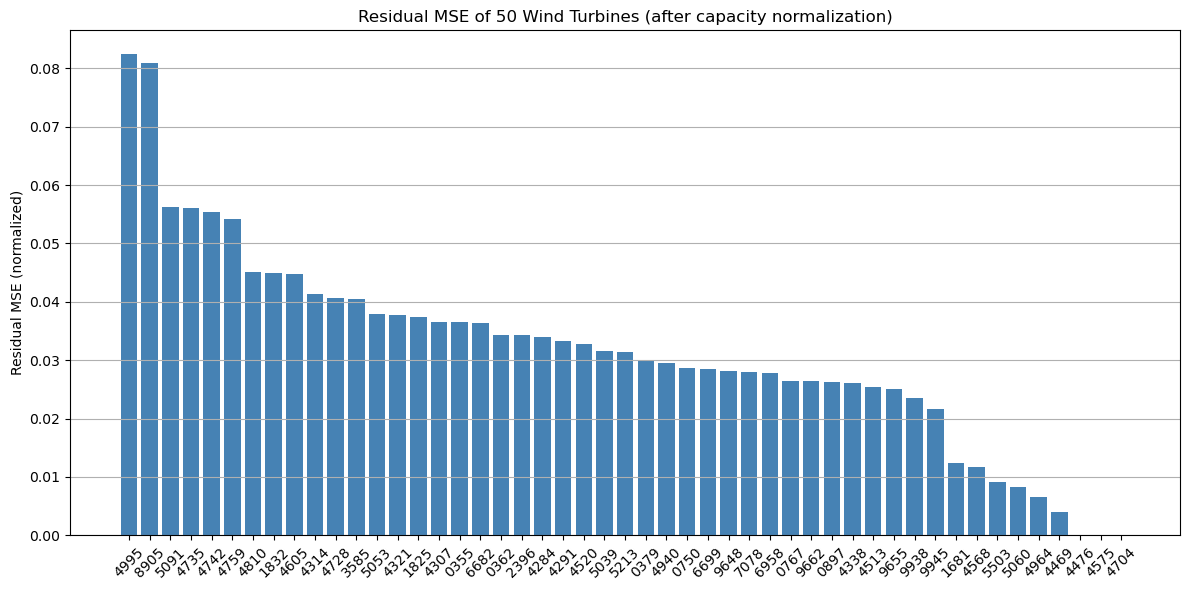

In [6]:
import matplotlib.pyplot as plt

# order by residual_mse descending
features_sorted = features_df.sort_values("residual_mse", ascending=False)

# draw bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    features_sorted["GSRN"].astype(str).str[-4:],  # 只显示 GSRN 后4位
    features_sorted["residual_mse"],
    color="steelblue"
)
plt.xticks(rotation=45)
plt.ylabel("Residual MSE (normalized)")
plt.title("Residual MSE of 50 Wind Turbines (after capacity normalization)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()